# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score, mean_absolute_error, mean_squared_error, roc_curve, roc_auc_score

# Dataset Load

In [2]:
# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')
data.head()

,Sequence,molecular \nweight,Theoretical Pi,Extinction \ncoefficient,Half life\n(hours),Instability\n index,Aliphatic\n index,GRAVY,Hydrophobic \nresidue :,Net charge:,Boman Index:\n(Kcal/mol),Protective Antigenic\n Score,Allergenicity,property = 1
0,GKPRPYSPRPTSHPRPIRV,2198.56,12.01,1490.0,30.0,41.15,35.79,-1.579,10.0,5.0,3.65,0.5017,no evidence,1
1,ACYCRIPACIAGERRYGTCIYQGRLWAFCC,3448.09,8.68,10345.0,4.4,55.71,65.33,0.3,53.0,3.0,1.07,0.4636,no evidence,1
2,FLFPLITSFLSKVL,1625.03,8.75,NaN,1.1,16.98,160.00,1.75,64.0,1.0,-1.61,0.4303,no evidence,1
3,SNDIYFNFQR,1303.40,5.55,1490.0,1.9,-6.03,39.00,-1.05,30.0,0.0,3.51,0.5745,strong evidence,1
4,GLFSVLGAVAKHVLPHVVPVIAEKL,2594.18,8.61,NaN,30.0,25.92,159.60,1.224,60.0,1.5,-1.13,0.4590,no evidence,1


# Class Distribution

property = 1
1    2082
0    1804
Name: count, dtype: int64


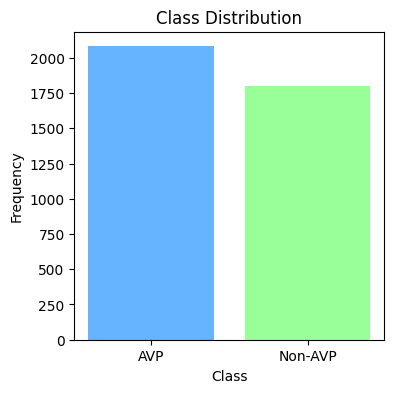

In [3]:
# Count the number of instances in each class
import matplotlib.pyplot as plt
class_counts = data['property = 1'].value_counts()

print(class_counts)

beingsaved = plt.figure(figsize=(4, 4))
colors = ['#66b3ff', '#99ff99']
plt.bar(['AVP', 'Non-AVP'], class_counts.values, color=colors)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
beingsaved.savefig('/kaggle/working/Class_Distribution.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Null Values

In [4]:
data.isna().sum()

 Sequence                         0
molecular \nweight                5
Theoretical Pi                    5
Extinction \ncoefficient        990
Half life\n(hours)                5
Instability\n index               5
Aliphatic\n index                 5
GRAVY                             7
Hydrophobic \nresidue :         115
Net charge:                     115
Boman Index:\n(Kcal/mol)        116
Protective Antigenic\n Score     19
Allergenicity                     2
property = 1                      0
dtype: int64

# Correlation Matrics

/tmp/ipykernel_17/2326518389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Attributes[column] = label_encoder.fit_transform(Attributes[column])
/tmp/ipykernel_17/2326518389.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Attributes[column] = label_encoder.fit_transform(Attributes[column])
/tmp/ipykernel_17/2326518389.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

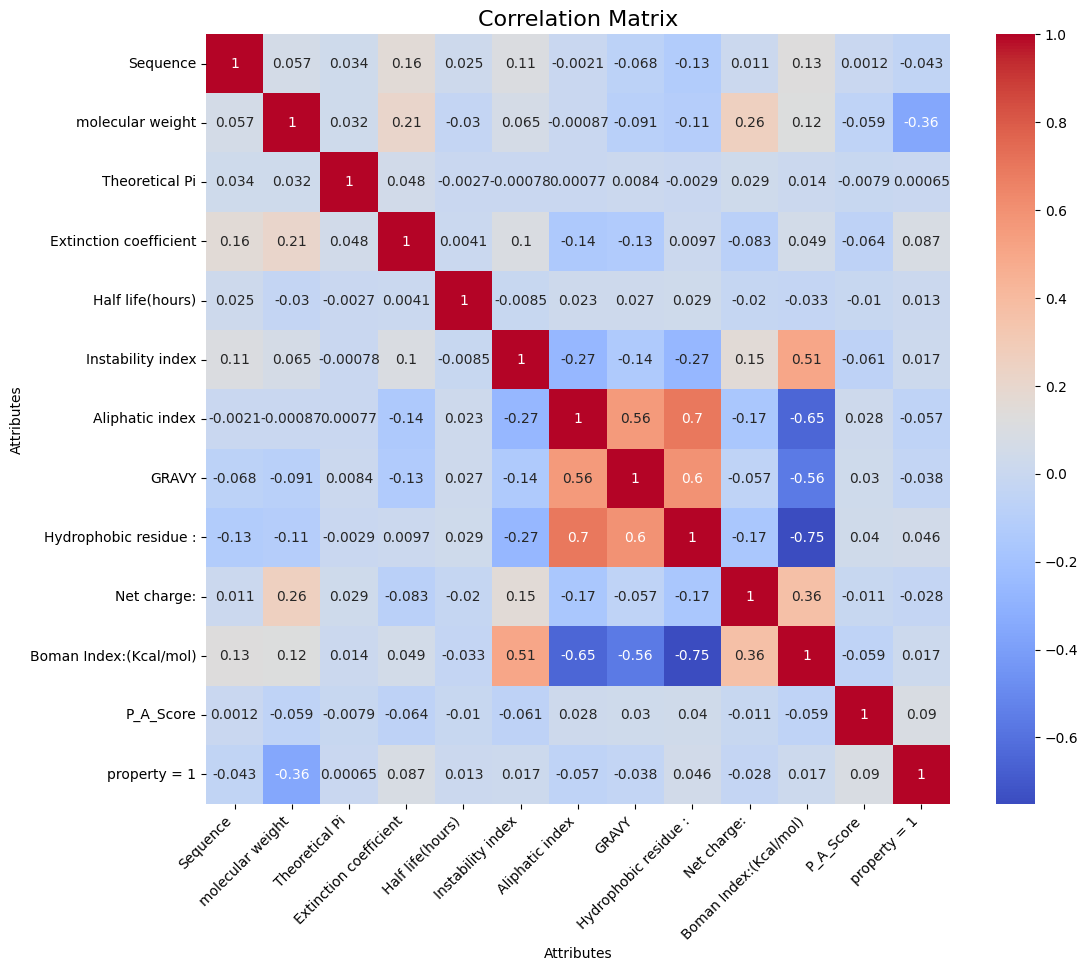

In [5]:
# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Select the features and labels
Attributes = data[['Sequence','molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 
                   'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 
                   'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score','property = 1']]

# Convert non-numeric columns to numeric using label encoding
label_encoder = LabelEncoder()
for column in Attributes.columns:
    if Attributes[column].dtype == object:
        Attributes[column] = label_encoder.fit_transform(Attributes[column])

# Modify column names
Attributes.rename(columns={'Protective Antigenic Score': 'P_A_Score'}, inplace=True)

# Calculate the correlation matrix
correlation_matrix = Attributes.corr()
beingsaved = plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Set title and labels
plt.title('Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
# Set the axis labels and title
plt.xlabel('Attributes')
plt.ylabel('Attributes')

beingsaved.savefig('/kaggle/working/Correlation Matrix.png', format='png', dpi=600, bbox_inches="tight")
plt.show()

# Machine Learning

In [6]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 'Half life\n(hours)', 
                   'Instability\n index', 'Aliphatic\n index', 'GRAVY', 'Hydrophobic \nresidue :', 
                   'Net charge:', 'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data using one-hot encoding and pad the sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Split the dataset into features (X) and target label (y)
X = data[['Sequence_Encoded', 'molecular weight','Extinction coefficient','Theoretical Pi', 'Half life(hours)', 
          'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 
          'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity']]
y = data['property = 1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded'])))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded'])))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)
X_test_balanced, y_test_balanced = smote.fit_resample(X_test_combined, y_test)

# Define the classifiers
classifiers = {
    'SVM': SVC(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),  # Increased max_iter
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier()
}

# Performance of Machine Learning

Model: SVM
Accuracy: 0.6905311778290993
F1 Score: 0.7130620985010707
Recall: 0.76905311778291
Precision: 0.6646706586826348
Mean Absolute Error: 0.3094688221709007
Root Mean Squared Error: 0.5562992199984651
ROC AUC Score: 0.6905311778290993
Confusion Matrix:
[[265 168]
 [100 333]]


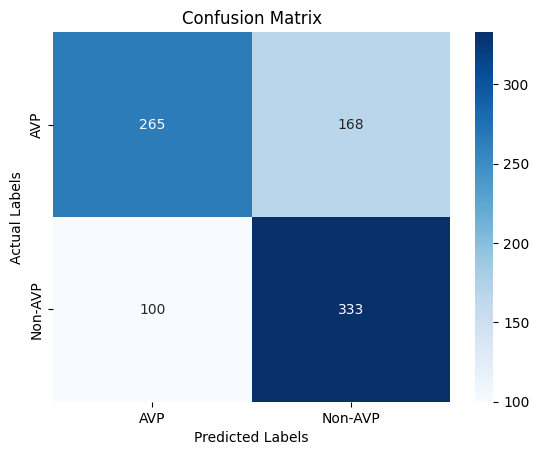

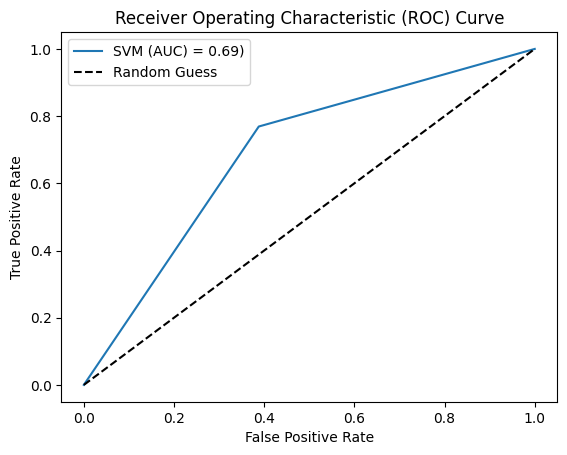

---------------------------------------
Model: Decision Tree
Accuracy: 0.754041570438799
F1 Score: 0.7582292849035187
Recall: 0.7713625866050808
Precision: 0.7455357142857143
Mean Absolute Error: 0.24595842956120093
Root Mean Squared Error: 0.49594196188788153
ROC AUC Score: 0.754041570438799
Confusion Matrix:
[[319 114]
 [ 99 334]]


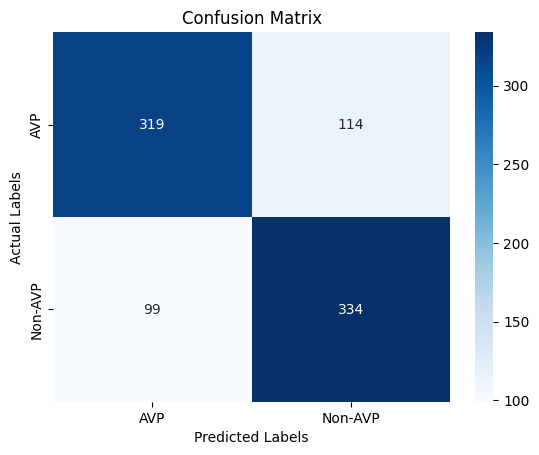

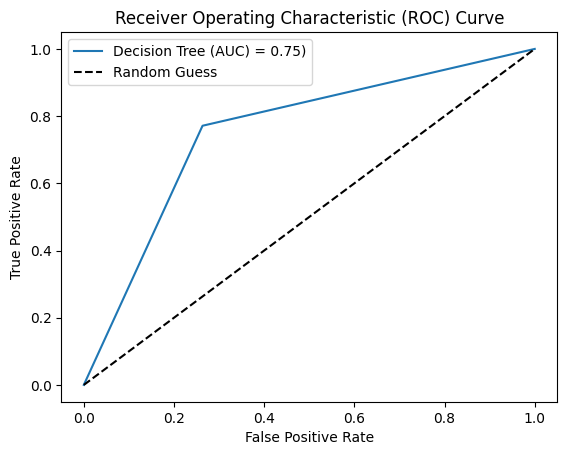

---------------------------------------
Model: Random Forest
Accuracy: 0.8383371824480369
F1 Score: 0.8461538461538461
Recall: 0.8891454965357968
Precision: 0.8071278825995807
Mean Absolute Error: 0.16166281755196305
Root Mean Squared Error: 0.4020731495038721
ROC AUC Score: 0.838337182448037
Confusion Matrix:
[[341  92]
 [ 48 385]]


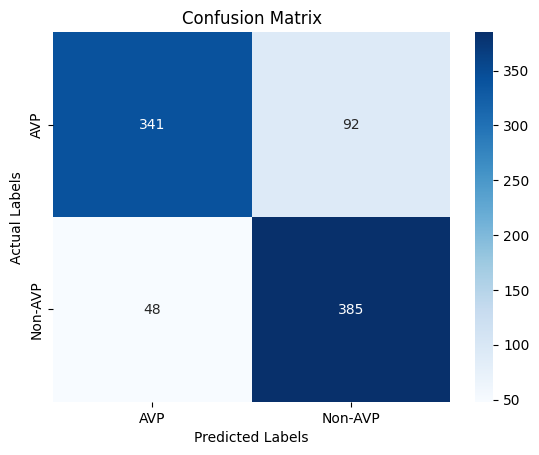

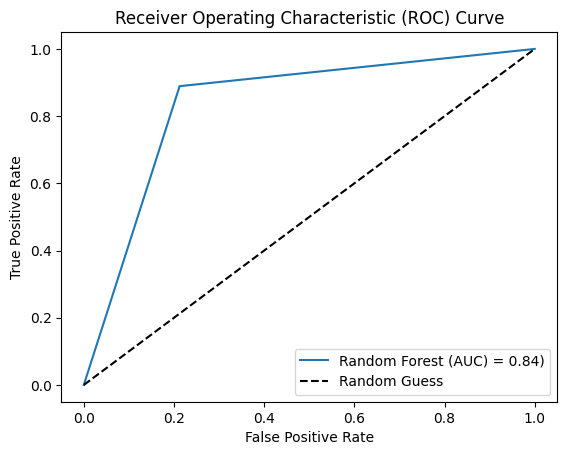

---------------------------------------
Model: Logistic Regression


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.6801385681293303
F1 Score: 0.6959385290889133
Recall: 0.7321016166281755
Precision: 0.6631799163179917
Mean Absolute Error: 0.31986143187066973
Root Mean Squared Error: 0.5655629336074542
ROC AUC Score: 0.6801385681293303
Confusion Matrix:
[[272 161]
 [116 317]]


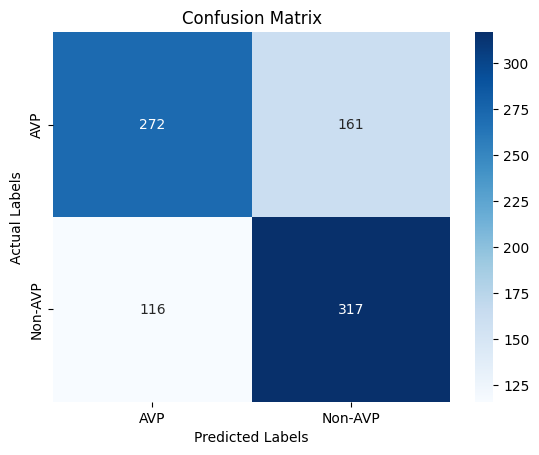

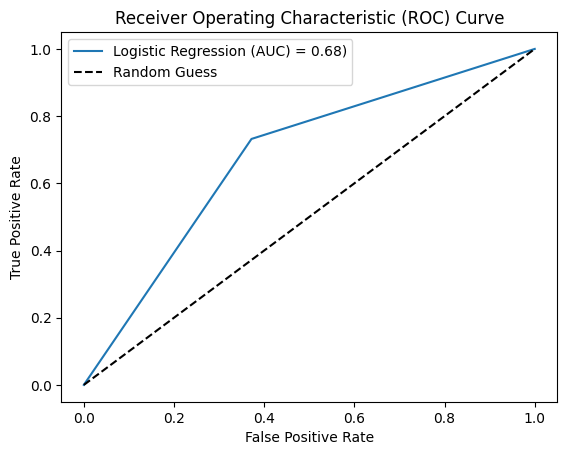

---------------------------------------
Model: Gradient Boosting
Accuracy: 0.8325635103926097
F1 Score: 0.8376259798432251
Recall: 0.8637413394919169
Precision: 0.8130434782608695
Mean Absolute Error: 0.1674364896073903
Root Mean Squared Error: 0.40919004094355754
ROC AUC Score: 0.8325635103926098
Confusion Matrix:
[[347  86]
 [ 59 374]]


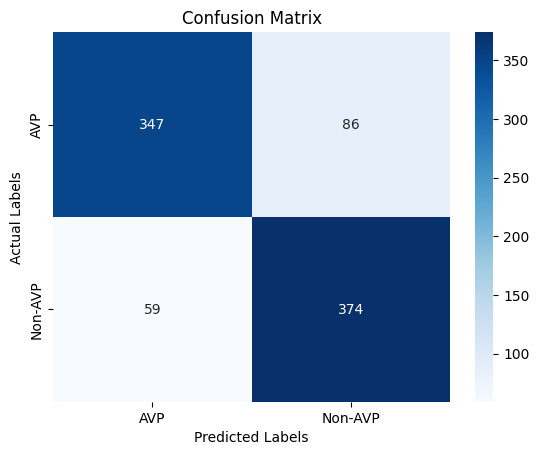

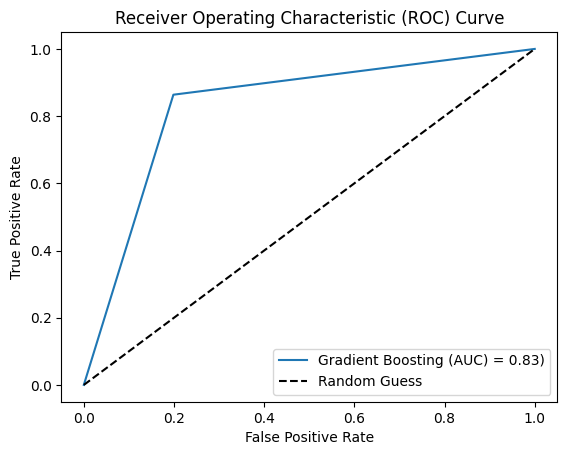

---------------------------------------
Model: K-Nearest Neighbors
Accuracy: 0.7725173210161663
F1 Score: 0.7711962833914053
Recall: 0.766743648960739
Precision: 0.7757009345794392
Mean Absolute Error: 0.22748267898383373
Root Mean Squared Error: 0.47695144300424724
ROC AUC Score: 0.7725173210161662
Confusion Matrix:
[[337  96]
 [101 332]]


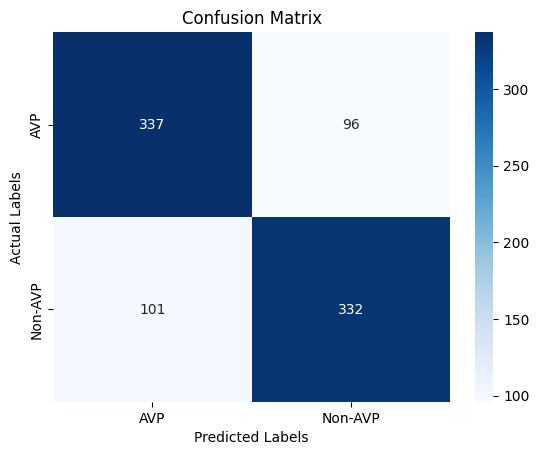

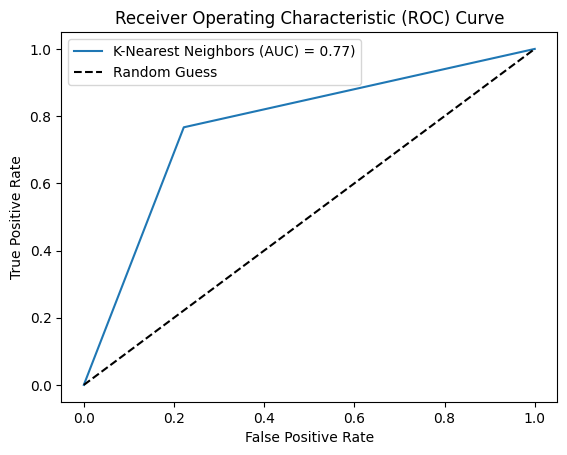

---------------------------------------
Model: Neural Network
Accuracy: 0.6339491916859122
F1 Score: 0.7245873153779322
Recall: 0.9630484988452656
Precision: 0.5807799442896936
Mean Absolute Error: 0.36605080831408776
Root Mean Squared Error: 0.6050213288092311
ROC AUC Score: 0.6339491916859122
Confusion Matrix:
[[132 301]
 [ 16 417]]


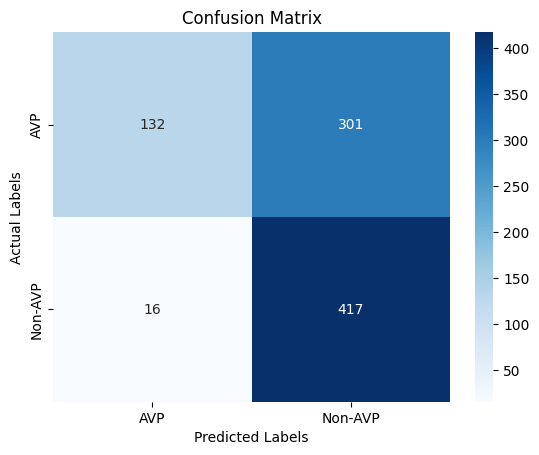

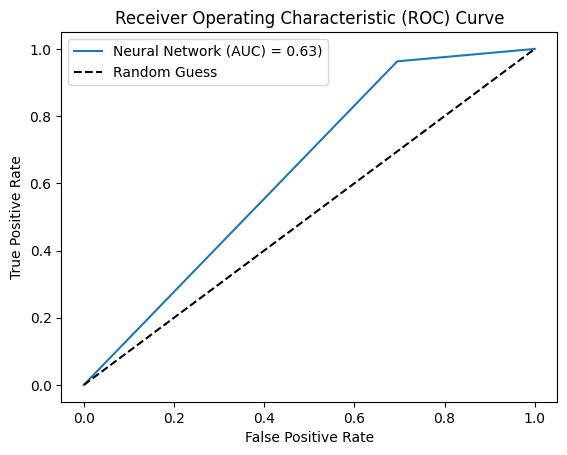

---------------------------------------


In [7]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, mean_absolute_error, mean_squared_error

# Train and evaluate each classifier
for name, classifier in classifiers.items():
    print(f"Model: {name}")
    
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_balanced)
    
    # Calculate the accuracy
    accuracy = accuracy_score(y_test_balanced, y_pred)

    # Create a confusion matrix
    cm = confusion_matrix(y_test_balanced, y_pred)

    print(f"Accuracy: {accuracy}")
    # Calculate F1 score
    f1 = f1_score(y_test_balanced, y_pred)
    print(f"F1 Score: {f1}")

    # Calculate recall
    recall = recall_score(y_test_balanced, y_pred)
    print(f"Recall: {recall}")

    # Calculate precision
    precision = precision_score(y_test_balanced, y_pred)
    print(f"Precision: {precision}")

    # Calculate mean absolute error
    mae = mean_absolute_error(y_test_balanced, y_pred)
    print(f"Mean Absolute Error: {mae}")

    # Calculate root mean squared error
    rmse = mean_squared_error(y_test_balanced, y_pred, squared=False)
    print(f"Root Mean Squared Error: {rmse}")

    # Calculate ROC AUC score
    roc_auc = roc_auc_score(y_test_balanced, y_pred)
    print(f"ROC AUC Score: {roc_auc}")
    
    print(f"Confusion Matrix:\n{cm}")

    # Create a heatmap of the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])

    # Set the axis labels and title
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix")

    # Display the confusion matrix
    plt.show()

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test_balanced, y_pred)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='{} (AUC) = {:.2f})'.format(name, roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()

    # Display the ROC curve
    plt.show()

    print("---------------------------------------")

# Ensemble Method

In [8]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode

# Load the CSV file
data = pd.read_csv('/kaggle/input/avped-dataset/AntiVped.csv')

# Convert non-numeric values to NaN for numeric columns
numeric_columns = ['molecular \nweight', 'Theoretical Pi', 'Extinction \ncoefficient', 
                   'Half life\n(hours)', 'Instability\n index', 'Aliphatic\n index', 
                   'GRAVY', 'Hydrophobic \nresidue :', 'Net charge:', 
                   'Boman Index:\n(Kcal/mol)', 'Protective Antigenic\n Score']

data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Fill missing values for numerical columns with their mean
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Fill missing values for the categorical column 'Allergenicity' with the most frequent value
data['Allergenicity'] = data['Allergenicity'].fillna(data['Allergenicity'].mode()[0])

# Clean up the column names
data.columns = data.columns.str.replace('\n', '').str.strip()

# Print the cleaned column names for verification
print("Cleaned Column Names:", data.columns.tolist())

# Encode the 'Allergenicity' column using LabelEncoder
label_encoder = LabelEncoder()
data['Allergenicity'] = label_encoder.fit_transform(data['Allergenicity'])

# Get unique amino acids in the dataset and create encoding
all_amino_acids = set(''.join(data['Sequence'].tolist()))
amino_acid_to_index = {amino_acid: i for i, amino_acid in enumerate(all_amino_acids)}

# Preprocess sequence data using one-hot encoding and pad the sequences
sequences_encoded = []
for sequence in data['Sequence']:
    encoded_sequence = [amino_acid_to_index[amino_acid] for amino_acid in sequence]
    sequences_encoded.append(encoded_sequence)

# Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences_encoded)
sequences_padded = pad_sequences(sequences_encoded, maxlen=max_sequence_length, padding='post')
data['Sequence_Encoded'] = sequences_padded.tolist()

# Check the columns before splitting
print("DataFrame Columns Before Splitting:", data.columns.tolist())

# Split the dataset into features (X) and target label (y)
try:
    X = data[['Sequence_Encoded', 'molecularweight', 'Extinctioncoefficient', 'TheoreticalPi', 
              'Halflife(hours)', 'Instabilityindex', 'Aliphaticindex', 'GRAVY', 
              'Hydrophobicresidue:', 'Netcharge:', 'BomanIndex:(Kcal/mol)', 
              'ProtectiveAntigenicScore', 'Allergenicity']]
    y = data['property = 1']
except KeyError as e:
    print(f"KeyError: {e}. Check the column names.")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sequence data to numpy arrays
X_train_sequences = np.array(X_train['Sequence_Encoded'].tolist())
X_test_sequences = np.array(X_test['Sequence_Encoded'].tolist())

# Flatten the sequence data
X_train_sequences_flat = X_train_sequences.reshape(X_train_sequences.shape[0], -1)
X_test_sequences_flat = X_test_sequences.reshape(X_test_sequences.shape[0], -1)

# Combine the flattened sequence data with other features
X_train_combined = np.hstack((X_train_sequences_flat, X_train.drop(columns=['Sequence_Encoded'])))
X_test_combined = np.hstack((X_test_sequences_flat, X_test.drop(columns=['Sequence_Encoded'])))

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_combined, y_train)

# Define the classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Train classifiers and store predictions
predictions = {}
for name, classifier in classifiers.items():
    classifier.fit(X_train_balanced, y_train_balanced)
    y_pred = classifier.predict(X_test_combined)  # Use the original test set
    predictions[name] = y_pred

# Custom ensemble method using majority voting
def custom_ensemble(predictions):
    # Stack predictions into a 2D array
    pred_array = np.array(list(predictions.values())).T
    # Use mode to find the most common prediction for each instance
    ensemble_predictions = mode(pred_array, axis=1)[0].flatten()
    return ensemble_predictions

# Get ensemble predictions
ensemble_predictions = custom_ensemble(predictions)

Cleaned Column Names: ['Sequence', 'molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity', 'property = 1']
DataFrame Columns Before Splitting: ['Sequence', 'molecular weight', 'Theoretical Pi', 'Extinction coefficient', 'Half life(hours)', 'Instability index', 'Aliphatic index', 'GRAVY', 'Hydrophobic residue :', 'Net charge:', 'Boman Index:(Kcal/mol)', 'Protective Antigenic Score', 'Allergenicity', 'property = 1', 'Sequence_Encoded']
KeyError: "['molecularweight', 'Extinctioncoefficient', 'TheoreticalPi', 'Halflife(hours)', 'Instabilityindex', 'Aliphaticindex', 'Hydrophobicresidue:', 'Netcharge:', 'BomanIndex:(Kcal/mol)', 'ProtectiveAntigenicScore'] not in index". Check the column names.


# Performance of Ensemble Method

Ensemble Accuracy: 0.8406169665809768
F1 Score: 0.8590909090909091
Recall: 0.8729792147806005
Precision: 0.8456375838926175
Mean Absolute Error: 0.15938303341902313
Root Mean Squared Error: 0.3992280468842628
ROC AUC Score: 0.8364896073903002
Confusion Matrix:
[[276  69]
 [ 55 378]]


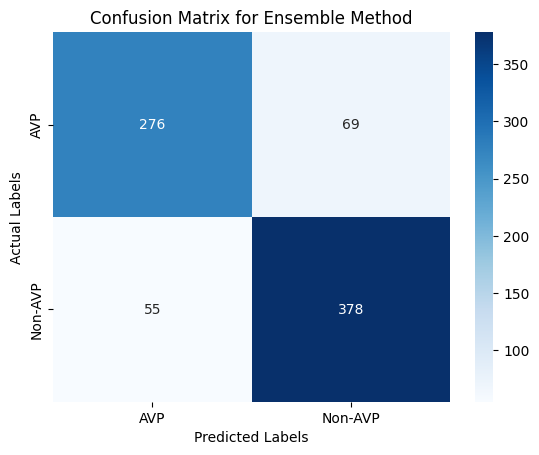

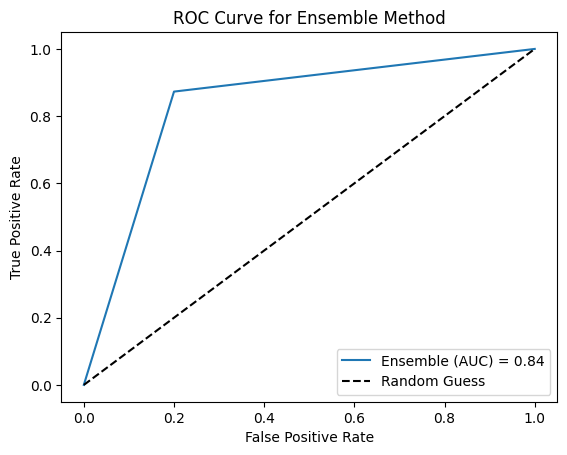

In [9]:
# Evaluate ensemble accuracy
accuracy = accuracy_score(y_test, ensemble_predictions)
print(f"Ensemble Accuracy: {accuracy}")

# Create a confusion matrix
cm = confusion_matrix(y_test, ensemble_predictions)

# Calculate F1 score
f1 = f1_score(y_test, ensemble_predictions)
print(f"F1 Score: {f1}")

# Calculate recall
recall = recall_score(y_test, ensemble_predictions)
print(f"Recall: {recall}")

# Calculate precision
precision = precision_score(y_test, ensemble_predictions)
print(f"Precision: {precision}")

# Calculate mean absolute error
mae = mean_absolute_error(y_test, ensemble_predictions)
print(f"Mean Absolute Error: {mae}")

# Calculate root mean squared error
rmse = mean_squared_error(y_test, ensemble_predictions, squared=False)
print(f"Root Mean Squared Error: {rmse}")

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, ensemble_predictions)
print(f"ROC AUC Score: {roc_auc}")

print(f"Confusion Matrix:\n{cm}")

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AVP", "Non-AVP"], yticklabels=["AVP", "Non-AVP"])

# Set the axis labels and title
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix for Ensemble Method")
plt.show()


# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, ensemble_predictions)

# Plot ROC curve
plt.plot(fpr, tpr, label='Ensemble (AUC) = {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ensemble Method')
plt.legend()
plt.show()